Import library

In [ ]:
import os
import numpy as np
import mediapipe as map
import matplotlib.pyplot as plt
import cv2
import time


preparing data

In [15]:
data2_path = 'raw_data2'
actions = ['falling0', 'lying', 'sitting', 'standing']

script for rename video

In [18]:
folder_path = data2_path

for i in actions:
    # List all files
    sub_folder = os.path.join(folder_path, i)
    files = sorted(os.listdir(sub_folder))

    for k, name in enumerate(files):
        try:
            oldname = os.path.join(data2_path, i, name)
            newname = os.path.join(data2_path, i, f'video_{k}.avi')
            os.rename(oldname, newname)
        except:
            pass
print("Done")
## raw_data2/falling0/yg (1).avi

Done


## the graphs below, I used for checking how many frames I should use.

In [16]:
source_folder = "raw_data2/falling0"
files = os.listdir(source_folder)
file_count = len(files)
print(file_count)

592


In [5]:
frame_num = []
for i in range(file_count):
    filename = f"video_{i}.avi"
    src_path = os.path.join(source_folder, filename)
    
    cap = cv2.VideoCapture(src_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_num.append(frame_count)

In [17]:
folder_path = data2_path
combine_frame_count = []

for i in actions:
    # List all files
    sub_folder = os.path.join(folder_path, i)
    files = sorted(os.listdir(sub_folder))

    files = os.listdir(sub_folder)
    file_count = len(files)
    
    frame_num = []

    for i in range(file_count):
        filename = f"video_{i}.avi"
        src_path = os.path.join(sub_folder, filename)


        
        cap = cv2.VideoCapture(src_path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_num.append(frame_count)
    combine_frame_count.append(frame_num)

    # for k, name in enumerate(files):
    #     print(k, sub_folder, name)

In [12]:
# Plotting
def plotting(framecount):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(framecount)), sorted(framecount), marker='o')
    plt.title('Frame Count per Video')
    plt.xlabel('Video Index')
    plt.ylabel('Frame Count')
    plt.grid(True)
    plt.show()

In [ ]:
for i in combine_frame_count:
    useable = []
    for j in i:
        if j >= 25 and j <= 35:
            useable.append(j)
    print(len(i), len(useable))


592 410
542 220
450 122
808 218


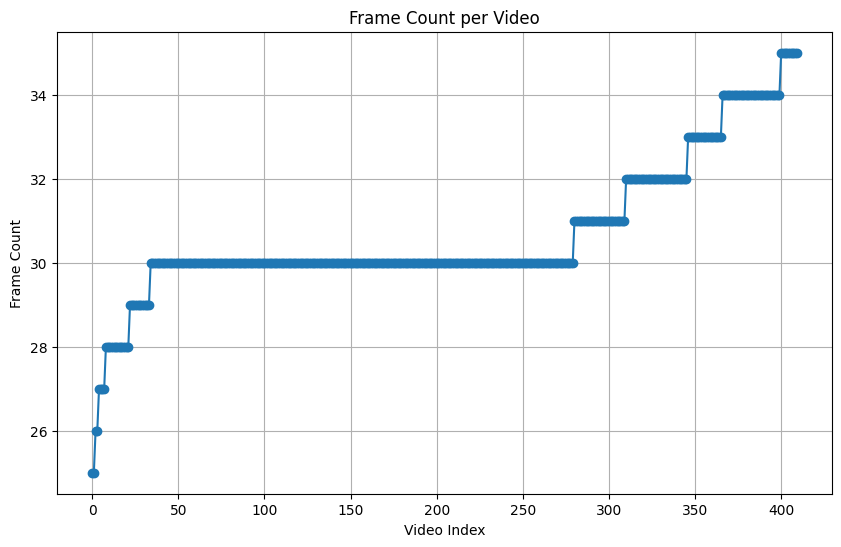

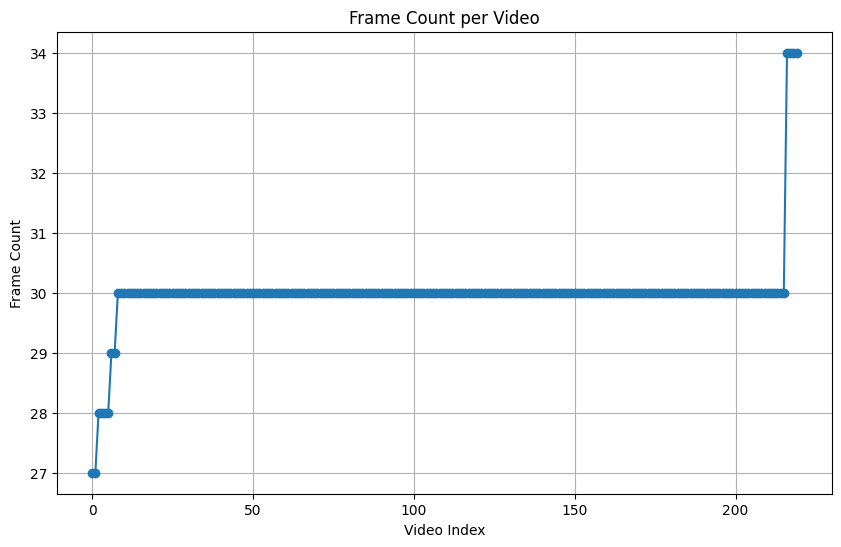

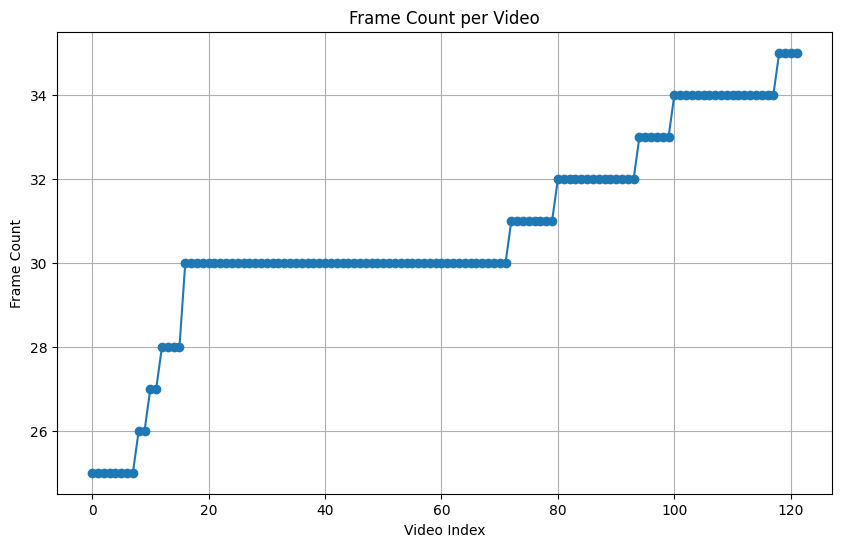

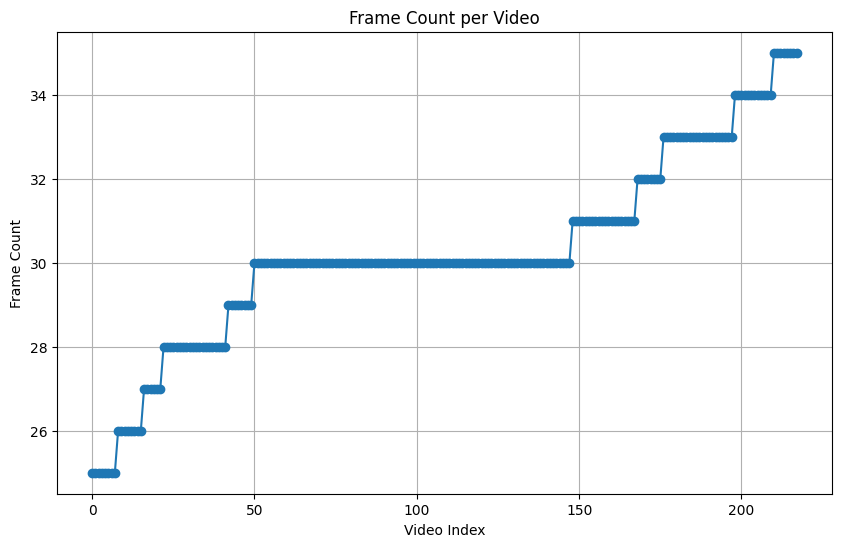

In [20]:
for i in combine_frame_count:
    useable = []
    for j in i:
        if j >= 25 and j <= 35:
            useable.append(j)
    plotting(useable)

# Extraction

In [21]:
data_path = os.path.join('30_data')
actions = np.array(['falling0', 'lying', 'sitting', 'standing'])

no_videos = 400
video_length = 30

main_folder = 'raw_data2'
destin_folder = '30_data'

# Don't run this code below
#### if you just looking through - do not run this code.
#### it take quite some time to run -- and might mess up the collected data
#### if you decide to run it though -- run the file call extract.py
#### run on this ipynb will crash midway so run it on noraml python file

In [ ]:
# Import MediaPipe's pose estimation and drawing utilities
mpPose = mp.solutions.pose
mpDraw = mp.solutions.drawing_utils
pose = mpPose.Pose() # Create a pose estimator object (with default settings)


# Loop through each action label
for action in actions:
    print(f"Processing action: {action}")

    # Construct path to videos and destination folder for this action
    src_folder = os.path.join(main_folder, action)
    save_action_folder = os.path.join(destin_folder, action)
    os.makedirs(save_action_folder, exist_ok=True) # Create folder if it doesn't exist

    # Counters for tracking how many videos are processed/saved
    collected = 0
    video_id = 0
    saved_video_idx = 0

    # Loop until desired number of videos is collected
    while collected < no_videos:
        file_location = os.path.join(src_folder, f'video_{video_id}.avi')

        # If video file is missing, skip it
        if not os.path.exists(file_location):
            video_id += 1
            if video_id > 10000: # Stop search after too many attempts
                print(f"Too many missing videos, stopping search for {action}")
                break
            continue

        # Open the video file
        cap = cv2.VideoCapture(file_location)
        frame_landmarks = [] # Store pose landmarks from each frame
        print(f"Processing {action} video {video_id} as index {saved_video_idx}...")

        # Read frames one by one
        while True:
            success, img = cap.read()
            if not success:
                break # Stop if end of video

            # Convert BGR to RGB for MediaPipe
            imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = pose.process(imgRGB) # Get pose landmarks

            # If pose landmarks are found, extract them
            if results.pose_landmarks:
                mpDraw.draw_landmarks(img, results.pose_landmarks, mpPose.POSE_CONNECTIONS) # (optional) draw pose
                pose_tmp = [np.array([res.x, res.y, res.z, res.visibility]) for res in results.pose_landmarks.landmark]
            else:
                pose_tmp = [np.zeros(4) for _ in range(33)] # make it 0 if pose not detected

            # Save the frame's flattened landmark array
            frame_landmarks.append(np.array(pose_tmp).flatten())

            # (Optional) show video framerate
            cTime = time.time()
            fps = 1/(cTime-pTime)
            pTime = cTime
            cv2.putText(img, str(int(fps)), (70,50), cv2.FONT_HERSHEY_PLAIN, 3, (255, 0, 0), 3)

            # (Optional) show the video that being capture
            cv2.imshow("Image", img)
            
            # press q to stop (but don't)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        

        cap.release() # Close the video file
        frame_count = len(frame_landmarks)

        # Skip short videos with less than 25 frames
        if frame_count < 25:
            print(f"Video {video_id} skipped, too short ({frame_count} frames).")
            video_id += 1
            continue

        # Normalize all videos to exactly 30 frames
        if 25 <= frame_count < 30:
            # Pad with last frame
            padding_needed = 30 - frame_count
            last_frame = frame_landmarks[-1]
            selected = frame_landmarks + [last_frame] * padding_needed
        elif 30 <= frame_count < 35:
            # Trim to 30 frames
            selected = frame_landmarks[:30]
        elif frame_count >= 35:
            # Trim to 30 frames
            selected = frame_landmarks[:30]
        else:
            selected = frame_landmarks  # Exactly 30 frames — no change

        # Save the processed frames as .npy files, one per frame
        save_to = os.path.join(save_action_folder, str(saved_video_idx))
        os.makedirs(save_to, exist_ok=True)

        for i, frame in enumerate(selected):
            np.save(os.path.join(save_to, f'{i}.npy'), frame)

        # Update counters
        collected += 1
        saved_video_idx += 1
        video_id += 1

    print(f"Finished {action}, total saved: {collected}")

cv2.destroyAllWindows() # Clean up any OpenCV windows (if used)